link gdrive : https://drive.google.com/drive/folders/1YwwKYx5nVoIPzTuQqHL_8tHS0heYF8A0?usp=sharing

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random

IMG_SIZE = (160, 160)
BATCH_SIZE = 16
NUM_CLASSES = 4
CLASS_NAMES_ORDER = ['bika ambon', 'kerak telor', 'papeda', 'plecing kangkung']
DATA_DIR = r"C:\Users\LENOVO\Projek-UAS-PMDPM_A_KERAS\dataset"

train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")
test_dir = os.path.join(DATA_DIR, "test")



In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Cek file bermasalah

In [19]:
ALLOWED_EXT = {".jpg", ".jpeg", ".png"} 
test_root = test_dir  

bad_files = []

for class_name in os.listdir(test_root):
    class_path = os.path.join(test_root, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        fpath = os.path.join(class_path, fname)
        ext = os.path.splitext(fname)[1].lower()
        if os.path.isfile(fpath) and ext not in ALLOWED_EXT:
            bad_files.append(fpath)

print("File bermasalah (tidak didukung):")
for bf in bad_files:
    print(" -", bf)

print("Jumlah file bermasalah:", len(bad_files))

File bermasalah (tidak didukung):
Jumlah file bermasalah: 0


## Data Loading

In [20]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical", 
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    shuffle = False
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# simpan nama kelas langsung dari dataset, JANGAN tulis manual
CLASS_NAMES = train_ds.class_names
print("Kelas (urutan index):", CLASS_NAMES)

# (opsional tapi bagus): prefetch biar training lebih cepat
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 241 files belonging to 4 classes.
Found 29 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Kelas (urutan index): ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


## Normalisasi Dan Augmentasi

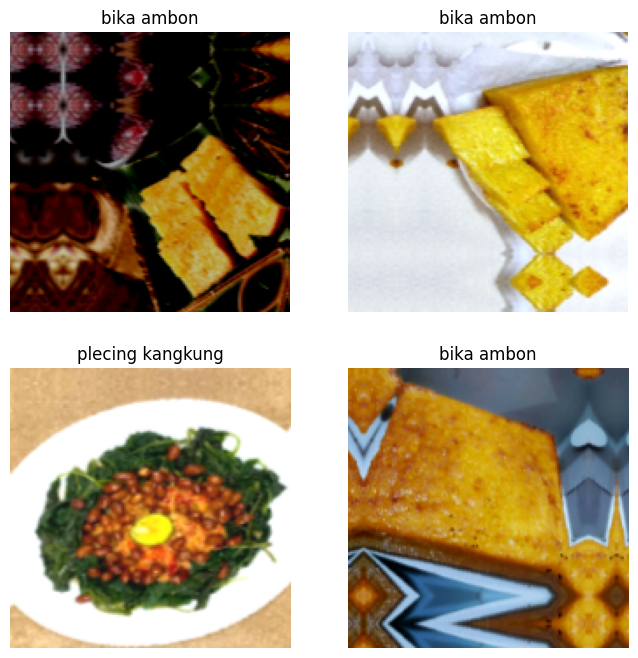

In [21]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3),
    layers.RandomTranslation(0.2, 0.2),
])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Helper untuk lihat sample data setelah augmentasi
def show_sample(dataset, n=4):
    plt.figure(figsize=(8,8))
    for images, labels in dataset.take(1):
        images = images[:n]
        labels = labels[:n]
        for i in range(n):
            ax = plt.subplot(2, 2, i + 1)
            aug_img = data_augmentation(images[i:i+1])
            plt.imshow(aug_img[0].numpy().astype("uint8"))
            class_idx = np.argmax(labels[i].numpy())
            plt.title(CLASS_NAMES_ORDER[class_idx])
            plt.axis("off")
    plt.show()

show_sample(train_ds, n=4) 

## 4. Blok Depthwise Separable Conv

In [22]:
# def depthwise_block(x, pointwise_filters, stride):
#     # Depthwise
#     x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding="same",  depthwise_regularizer=l2(0.0005))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU(6.0)(x)

#     # Pointwise (1x1)
#     x = layers.Conv2D(pointwise_filters, kernel_size=1, strides=1, padding="same", kernel_regularizer=l2(0.0005))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU(6.0)(x)
#     return x

def depthwise_separable_block(x, pointwise_filters, stride):
    # depthwise
    x = layers.DepthwiseConv2D(
        kernel_size=3,
        strides=stride,
        padding="same"
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # pointwise
    x = layers.Conv2D(
        pointwise_filters,
        kernel_size=1,
        strides=1,
        padding="same"
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # dropout kecil di tiap blok supaya model ga terlalu nempel ke 1 kelas
    x = layers.Dropout(0.25)(x)
    return x

## 5. Arsitektur MobileNet-style

In [23]:


def depthwise_separable_block(x, filters, stride):
    x = layers.DepthwiseConv2D(3, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)
    x = layers.Conv2D(filters, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)
    x = layers.Dropout(0.25)(x)
    return x

def build_mobilenet_small(input_shape=(160,160,3), num_classes=4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # Lebih sedikit blok (biar gak overfit)
    x = depthwise_separable_block(x, 64, 1)
    x = depthwise_separable_block(x, 128, 2)
    x = depthwise_separable_block(x, 256, 2)
    x = depthwise_separable_block(x, 512, 2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

model = build_mobilenet_small()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## 6. Modile Compile

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## 7. Training

In [25]:
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                     # boleh 20 atau 30
    callbacks=[earlystop, reduceLR]
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.3942 - loss: 1.3131 - val_accuracy: 0.2759 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5228 - loss: 1.1318 - val_accuracy: 0.2759 - val_loss: 1.3930 - learning_rate: 0.0010
Epoch 3/20
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6227 - loss: 0.9130
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.5809 - loss: 0.9420 - val_accuracy: 0.2759 - val_loss: 1.4183 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5851 - loss: 0.9319 - val_accuracy: 0.2759 - val_loss: 1.4409 - learning_rate: 5.0000e-04


## 8. Plot akurasi & loss

   accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.394191  1.313089      0.275862  1.385287         0.0010
1  0.522822  1.131838      0.275862  1.393008         0.0010
2  0.580913  0.941999      0.275862  1.418273         0.0010
3  0.585062  0.931905      0.275862  1.440870         0.0005


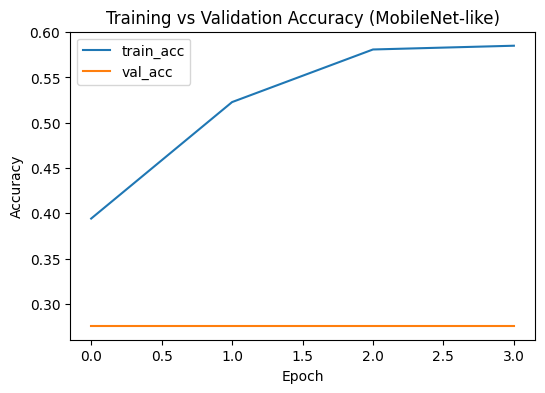

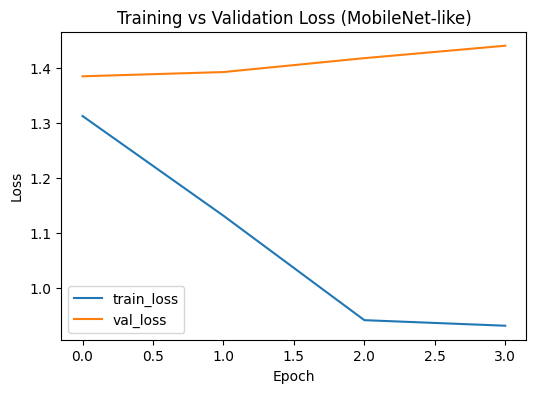

In [26]:
hist_df = pd.DataFrame(history.history)
print(hist_df.head())

plt.figure(figsize=(6,4))
plt.plot(hist_df["accuracy"], label="train_acc")
plt.plot(hist_df["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (MobileNet-like)")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_df["loss"], label="train_loss")
plt.plot(hist_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MobileNet-like)")
plt.legend()
plt.show()

## 9. evaluasi di test set

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2500 - loss: 1.3876    
Test Loss : 1.3876094818115234
Test Acc  : 0.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


<Figure size 500x500 with 0 Axes>

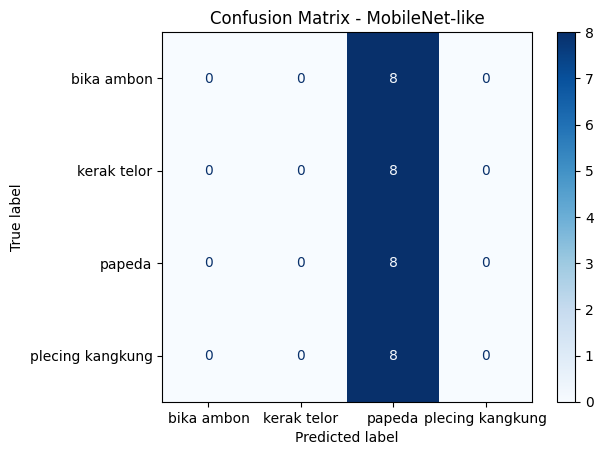

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


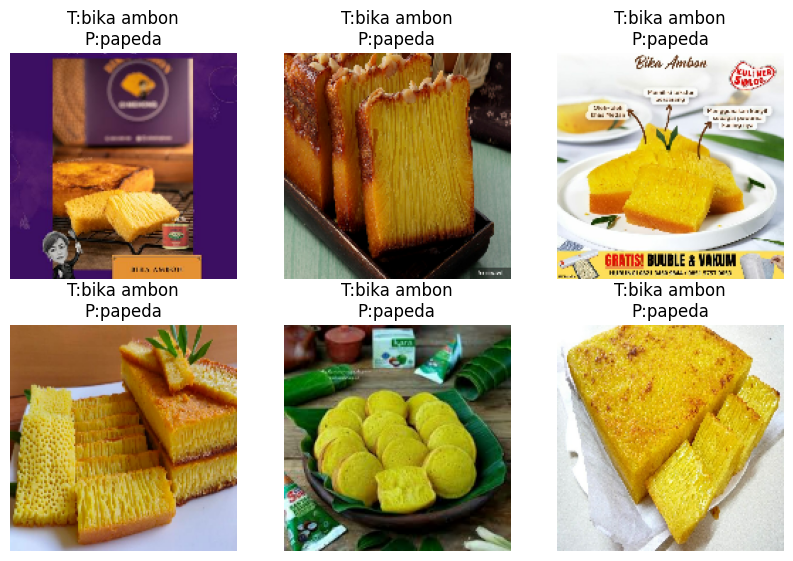

In [27]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss :", test_loss)
print("Test Acc  :", test_acc)

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=CLASS_NAMES_ORDER)
plt.figure(figsize=(5,5))
disp.plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix - MobileNet-like")
plt.show()

# Tampilkan beberapa prediksi contoh
def show_predictions(dataset, n=6):
    plt.figure(figsize=(10,10))
    idx_plot = 1
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(n):
            ax = plt.subplot(3, 3, idx_plot)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_idx = np.argmax(labels[i].numpy())
            pred_idx = np.argmax(preds[i])
            plt.title(f"T:{CLASS_NAMES_ORDER[true_idx]}\nP:{CLASS_NAMES_ORDER[pred_idx]}")
            plt.axis("off")
            idx_plot += 1
    plt.show()

show_predictions(test_ds, n=6)


## 10. Simpan model .h5
model.save("BestModel_MobileNet_A_KERAS.h5")
print("Model disimpan sebagai BestModel_MobileNet_A_KERAS.h5")

In [28]:
model.save("../models/BestModel_MobileNet_A_KERAS.h5")
print("Model disimpan sebagai BestModel_MobileNet_A_KERAS.h5")

TypeError: cannot pickle 'module' object